Using xgboost or a random forest regressor to determine relevant features

In [1]:
strat_univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT',
              'BCHUSDT', ]

In [2]:
from binance.client import Client as bnb_client
from binance.client import BinanceAPIException
from datetime import datetime
import pandas as pd

client = bnb_client(tld='US')

def get_price_data_for_coin(coin, freq, start_date):
    bn_data = client.get_historical_klines(coin, freq, start_date)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

    bn_data = pd.DataFrame(bn_data, columns=columns)
    bn_data['open_time'] = bn_data['open_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    bn_data['close_time'] = bn_data['close_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    return bn_data


def get_price_data_for_universe(freq, start_date):
    px_data = {}

    for coin in strat_univ:
        try:
            px_data[coin] = get_price_data_for_coin(coin, freq, start_date).set_index('open_time')
            print(f"Downloaded data for {coin}.")
        except BinanceAPIException:
            print(f"Couldn't load data for {coin}.")
    
    return px_data

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
data_freq = '4h'
day_periods = 6

look_back_window_size = 30 * 6
look_back_min_periods = 10 * 6
start_datetime = '2020-01-01 00:00:00'
in_sample_end_datetime = pd.to_datetime('2022-08-05 04:00:00')
# in_sample_end_datetime = pd.to_datetime('2023-12-31 20:00:00')

In [4]:
px_data = get_price_data_for_universe(data_freq, start_datetime)

Downloaded data for BTCUSDT.
Downloaded data for ETHUSDT.
Downloaded data for ADAUSDT.
Downloaded data for BNBUSDT.
Downloaded data for XRPUSDT.
Downloaded data for DOTUSDT.
Downloaded data for MATICUSDT.


In [17]:
import numpy as np

def get_signals(price_volume_df):
    coin_signals_data = dict()
    #coin_signals = pd.DataFrame(0.0, columns = [], index=price_volume_df.index)

    coin_signals_data["price-1"] = price_volume_df["close"].shift()
    coin_signals_data["price-2"] = price_volume_df["close"].shift(2)
    coin_signals_data["price-3"] = price_volume_df["close"].shift(3)
    coin_signals_data["log price-1"] = np.log(coin_signals_data["price-1"])
    coin_signals_data["log price-2"] = np.log(coin_signals_data["price-2"])
    coin_signals_data["log price-3"] = np.log(coin_signals_data["price-3"])
    coin_signals_data["price-1 - price-2"] = coin_signals_data["price-1"] - coin_signals_data["price-2"]
    coin_signals_data["price-2 - price-3"] = coin_signals_data["price-2"] - coin_signals_data["price-3"]
    coin_signals_data["price-1 - price-3"] = coin_signals_data["price-1"] - coin_signals_data["price-3"]
    coin_signals_data["price change rate 1-2"] = coin_signals_data["price-1"] / coin_signals_data["price-2"] - 1
    coin_signals_data["price change rate 2-3"] = coin_signals_data["price-2"] / coin_signals_data["price-3"] - 1
    coin_signals_data["log price quotient 1-2"] = np.log(coin_signals_data["price-1"] / coin_signals_data["price-2"])
    coin_signals_data["log price quotient 2-3"] = np.log(coin_signals_data["price-2"] / coin_signals_data["price-3"])

    coin_signals_data["volume-1"] = price_volume_df["volume"].shift()
    coin_signals_data["volume-1"].loc[coin_signals_data["volume-1"] == 0] = 0.001
    coin_signals_data["volume-2"] = price_volume_df["volume"].shift(2)
    coin_signals_data["volume-2"].loc[coin_signals_data["volume-2"] == 0] = 0.001
    coin_signals_data["volume-3"] = price_volume_df["volume"].shift(3)
    coin_signals_data["volume-3"].loc[coin_signals_data["volume-3"] == 0] = 0.001
    coin_signals_data["log volume-1"] = np.log(coin_signals_data["volume-1"])
    coin_signals_data["log volume-2"] = np.log(coin_signals_data["volume-2"])
    coin_signals_data["log volume-3"] = np.log(coin_signals_data["volume-3"])
    coin_signals_data["volume-1 - volume-2"] = coin_signals_data["volume-1"] - coin_signals_data["volume-2"]
    coin_signals_data["volume-2 - volume-3"] = coin_signals_data["volume-2"] - coin_signals_data["volume-3"]
    coin_signals_data["volume-1 - volume-3"] = coin_signals_data["volume-1"] - coin_signals_data["volume-3"]
    coin_signals_data["volume change rate 1-2"] = coin_signals_data["volume-1"] / coin_signals_data["volume-2"] - 1
    coin_signals_data["volume change rate 2-3"] = coin_signals_data["volume-2"] / coin_signals_data["volume-3"] - 1
    coin_signals_data["log volume quotient 1-2"] = np.log(coin_signals_data["volume-1"] / coin_signals_data["volume-2"])
    coin_signals_data["log volume quotient 2-3"] = np.log(coin_signals_data["volume-2"] / coin_signals_data["volume-3"])
    coin_signals_data["num trades-1"] = price_volume_df["num_trades"].shift()

    price_columns = [
        "price-1", "price-2", "price-3", "log price-1", "log price-2", "log price-3", "price-1 - price-2",
        "price-2 - price-3", "price-1 - price-3", "price change rate 1-2", "price change rate 2-3",
        "log price quotient 1-2", "log price quotient 2-3"]

    volume_columns = [
        "volume-1", "volume-2", "volume-3", "log volume-1", "log volume-2", "log volume-3",
        "volume-1 - volume-2", "volume-2 - volume-3", "volume-1 - volume-3", "volume change rate 1-2",
        "volume change rate 2-3", "log volume quotient 1-2", "log volume quotient 2-3", "num trades-1"
    ]

    for p_col in price_columns:
        for v_col in volume_columns:
            coin_signals_data[p_col + " x " + v_col] = coin_signals_data[p_col] * coin_signals_data[v_col]
    
    return pd.DataFrame(coin_signals_data, index=price_volume_df.index)


def get_signals_for_all_coins(px_data):
    coin_to_signals = dict()

    for coin in px_data:
        price_volume_df = px_data[coin][["close", "volume", "num_trades"]].astype(float)
        #price_volume_df = px_data[coin][
        #    ["close", "quote_volume"]].rename({"quote_volume": "volume"}, axis=1).astype(float)
        coin_to_signals[coin] = get_signals(price_volume_df)
    
    return coin_to_signals

In [18]:
px_data['BTCUSDT']['close']

open_time
2020-01-01 00:00:00     7230.71000000
2020-01-01 04:00:00     7205.50000000
2020-01-01 08:00:00     7195.80000000
2020-01-01 12:00:00     7233.02000000
2020-01-01 16:00:00     7223.72000000
                            ...      
2025-03-10 16:00:00    79046.81000000
2025-03-10 20:00:00    78554.25000000
2025-03-11 00:00:00    79420.81000000
2025-03-11 04:00:00    80510.98000000
2025-03-11 08:00:00    81830.54000000
Name: close, Length: 11373, dtype: object

In [19]:
m = len(px_data['BTCUSDT'].index)
px_data['BTCUSDT'].index[int(m * 0.5)]


Timestamp('2022-08-06 12:00:00')

In [20]:
from sklearn.ensemble import RandomForestRegressor

coin_to_signals = get_signals_for_all_coins(px_data)
coin_to_rfr_model = dict()

for coin, signals in coin_to_signals.items():
    rfr_model = RandomForestRegressor(random_state=836, max_depth=5)
    
    in_sample_signals = signals.iloc[3:].loc[:in_sample_end_datetime]
    in_sample_close_price = px_data[coin]['close'].iloc[3:].loc[:in_sample_end_datetime]
    
    rfr_model.fit(in_sample_signals, in_sample_close_price)
    coin_to_rfr_model[coin] = rfr_model
    print(f"Model fitted for {coin}.")

Model fitted for BTCUSDT.
Model fitted for ETHUSDT.
Model fitted for ADAUSDT.
Model fitted for BNBUSDT.
Model fitted for XRPUSDT.
Model fitted for DOTUSDT.
Model fitted for MATICUSDT.


In [21]:
coin_to_rfr_model['BTCUSDT']

RandomForestRegressor(max_depth=5, random_state=836)

<Axes: xlabel='open_time'>

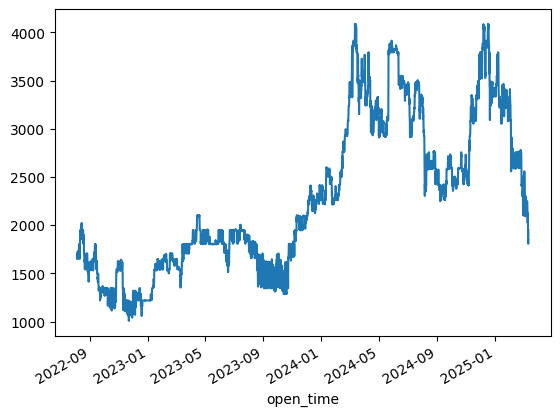

In [22]:
from datetime import timedelta

out_sample_start_datetime = in_sample_end_datetime + timedelta(hours=4)
eth_signals_out_sample = coin_to_signals['ETHUSDT'].loc[out_sample_start_datetime:]
eth_out_sample_predictions = coin_to_rfr_model['ETHUSDT'].predict(eth_signals_out_sample)
eth_out_sample_predictions = pd.Series(eth_out_sample_predictions, index=eth_signals_out_sample.index)

eth_out_sample_predictions.plot()

<Axes: xlabel='open_time'>

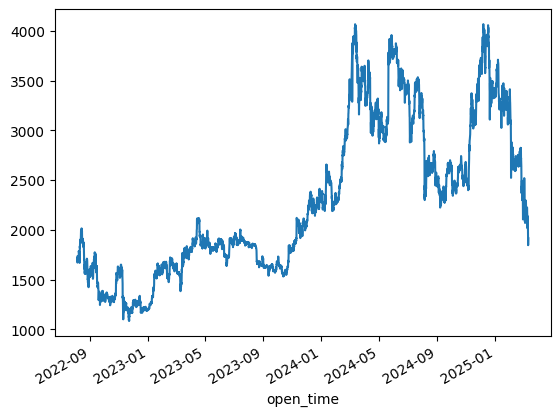

In [23]:
eth_price = px_data['ETHUSDT'].loc[out_sample_start_datetime:]['close'].astype(float)
eth_price.plot()

<Axes: xlabel='open_time'>

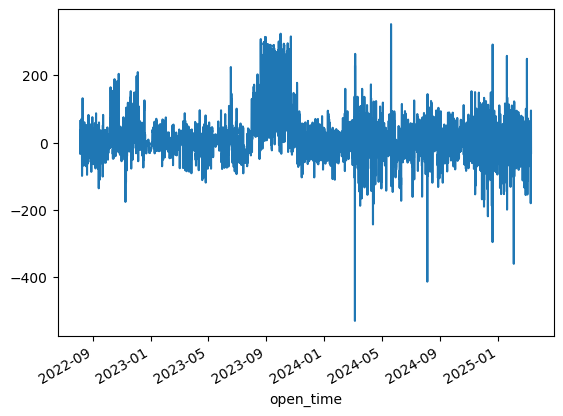

In [24]:
(eth_price - eth_out_sample_predictions).plot()

In [25]:
(eth_price - eth_out_sample_predictions).mean()

13.423773748719515

In [26]:
eth_residuals = eth_price - eth_out_sample_predictions
mean = eth_residuals.mean()
std = eth_residuals.std()

(eth_residuals - mean) / std

open_time
2022-08-05 08:00:00    0.758190
2022-08-05 12:00:00   -0.707083
2022-08-05 16:00:00    0.226430
2022-08-05 20:00:00    0.337564
2022-08-06 00:00:00   -0.129637
                         ...   
2025-03-10 16:00:00   -2.906375
2025-03-10 20:00:00    0.167932
2025-03-11 00:00:00   -0.309094
2025-03-11 04:00:00    1.228595
2025-03-11 08:00:00   -0.667296
Length: 5694, dtype: float64

In [27]:
coin_to_z_scores = dict()

for coin, model in coin_to_rfr_model.items():
    signals_out_sample = coin_to_signals[coin].loc[out_sample_start_datetime:]
    out_sample_predictions = model.predict(signals_out_sample)
    out_sample_predictions = pd.Series(out_sample_predictions, index=signals_out_sample.index)
    out_sample_price = px_data[coin].loc[out_sample_start_datetime:]['close'].astype(float)
    
    residuals = out_sample_price - out_sample_predictions
    residuals_mean = residuals.mean()
    residuals_std = residuals.std()
    z_scores = (residuals - residuals_mean) / residuals_std
    
    coin_to_z_scores[coin] = z_scores

# eth_out_sample_predictions.plot()

In [28]:
coin_to_z_scores

{'BTCUSDT': open_time
 2022-08-05 08:00:00   -0.404694
 2022-08-05 12:00:00   -0.442006
 2022-08-05 16:00:00   -0.449626
 2022-08-05 20:00:00   -0.413442
 2022-08-06 00:00:00   -0.427449
                          ...   
 2025-03-10 16:00:00    0.926135
 2025-03-10 20:00:00    0.879683
 2025-03-11 00:00:00    0.961406
 2025-03-11 04:00:00    1.064218
 2025-03-11 08:00:00    1.188662
 Length: 5694, dtype: float64,
 'ETHUSDT': open_time
 2022-08-05 08:00:00    0.758190
 2022-08-05 12:00:00   -0.707083
 2022-08-05 16:00:00    0.226430
 2022-08-05 20:00:00    0.337564
 2022-08-06 00:00:00   -0.129637
                          ...   
 2025-03-10 16:00:00   -2.906375
 2025-03-10 20:00:00    0.167932
 2025-03-11 00:00:00   -0.309094
 2025-03-11 04:00:00    1.228595
 2025-03-11 08:00:00   -0.667296
 Length: 5694, dtype: float64,
 'ADAUSDT': open_time
 2022-08-05 08:00:00    0.286168
 2022-08-05 12:00:00   -0.111659
 2022-08-05 16:00:00    0.169170
 2022-08-05 20:00:00    0.329496
 2022-08-06 00

In [29]:
coin_to_z_scores_df = pd.DataFrame(coin_to_z_scores)
coin_to_z_scores_df

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2022-08-05 08:00:00,-0.404694,0.758190,0.286168,-0.057271,NaN,1.328017,0.277609
2022-08-05 12:00:00,-0.442006,-0.707083,-0.111659,-0.361348,NaN,0.850293,-1.107682
2022-08-05 16:00:00,-0.449626,0.226430,0.169170,-0.283784,NaN,1.285049,-0.117269
2022-08-05 20:00:00,-0.413442,0.337564,0.329496,-0.195587,NaN,1.568781,1.354821
2022-08-06 00:00:00,-0.427449,-0.129637,0.215858,-0.238255,NaN,0.950746,0.528129
...,...,...,...,...,...,...,...
2025-03-10 16:00:00,0.926135,-2.906375,-2.029099,-1.453248,1.525907,-1.858965,NaN
2025-03-10 20:00:00,0.879683,0.167932,-2.112149,-0.334564,1.446509,-1.921268,NaN
2025-03-11 00:00:00,0.961406,-0.309094,-0.574274,0.013989,1.485337,-1.862188,NaN


In [30]:
coin_to_z_scores_df.rank(axis=1)

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2022-08-05 08:00:00,1.0,5.0,4.0,2.0,NaN,6.0,3.0
2022-08-05 12:00:00,3.0,2.0,5.0,4.0,NaN,6.0,1.0
2022-08-05 16:00:00,1.0,5.0,4.0,2.0,NaN,6.0,3.0
2022-08-05 20:00:00,1.0,4.0,3.0,2.0,NaN,6.0,5.0
2022-08-06 00:00:00,1.0,3.0,4.0,2.0,NaN,6.0,5.0
...,...,...,...,...,...,...,...
2025-03-10 16:00:00,5.0,1.0,2.0,4.0,6.0,3.0,NaN
2025-03-10 20:00:00,5.0,4.0,1.0,3.0,6.0,2.0,NaN
2025-03-11 00:00:00,5.0,3.0,2.0,4.0,6.0,1.0,NaN


In [31]:
ranked_z_scores = coin_to_z_scores_df.rank(axis=1)
demeaned_ranked_z_scores = ranked_z_scores.subtract(ranked_z_scores.mean(axis=1), axis=0)
demeaned_ranked_z_scores

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2022-08-05 08:00:00,-2.5,1.5,0.5,-1.5,NaN,2.5,-0.5
2022-08-05 12:00:00,-0.5,-1.5,1.5,0.5,NaN,2.5,-2.5
2022-08-05 16:00:00,-2.5,1.5,0.5,-1.5,NaN,2.5,-0.5
2022-08-05 20:00:00,-2.5,0.5,-0.5,-1.5,NaN,2.5,1.5
2022-08-06 00:00:00,-2.5,-0.5,0.5,-1.5,NaN,2.5,1.5
...,...,...,...,...,...,...,...
2025-03-10 16:00:00,1.5,-2.5,-1.5,0.5,2.5,-0.5,NaN
2025-03-10 20:00:00,1.5,0.5,-2.5,-0.5,2.5,-1.5,NaN
2025-03-11 00:00:00,1.5,-0.5,-1.5,0.5,2.5,-2.5,NaN


In [32]:
port_positions = -1 * demeaned_ranked_z_scores.divide(demeaned_ranked_z_scores.abs().sum(axis=1), axis=0)
port_positions

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2022-08-05 08:00:00,0.277778,-0.166667,-0.055556,0.166667,NaN,-0.277778,0.055556
2022-08-05 12:00:00,0.055556,0.166667,-0.166667,-0.055556,NaN,-0.277778,0.277778
2022-08-05 16:00:00,0.277778,-0.166667,-0.055556,0.166667,NaN,-0.277778,0.055556
2022-08-05 20:00:00,0.277778,-0.055556,0.055556,0.166667,NaN,-0.277778,-0.166667
2022-08-06 00:00:00,0.277778,0.055556,-0.055556,0.166667,NaN,-0.277778,-0.166667
...,...,...,...,...,...,...,...
2025-03-10 16:00:00,-0.166667,0.277778,0.166667,-0.055556,-0.277778,0.055556,NaN
2025-03-10 20:00:00,-0.166667,-0.055556,0.277778,0.055556,-0.277778,0.166667,NaN
2025-03-11 00:00:00,-0.166667,0.055556,0.166667,-0.055556,-0.277778,0.277778,NaN


In [33]:
close_price_df = pd.DataFrame({ticker: px_data[ticker]["close"] for ticker in px_data}).astype(float)
close_price_out_sample_df = close_price_df.loc[out_sample_start_datetime:]
close_price_out_sample_df

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2022-08-05 08:00:00,23411.10,1714.07,0.51615,318.0515,NaN,8.550,0.933
2022-08-05 12:00:00,23015.46,1672.04,0.50670,313.3216,NaN,8.370,0.902
2022-08-05 16:00:00,22934.66,1680.88,0.50989,314.5281,NaN,8.510,0.903
2022-08-05 20:00:00,23318.34,1738.40,0.51742,315.9000,NaN,8.830,0.927
2022-08-06 00:00:00,23169.82,1733.57,0.51630,315.2363,NaN,8.680,0.936
...,...,...,...,...,...,...,...
2025-03-10 16:00:00,79046.81,1867.60,0.68840,535.2200,2.0740,3.926,NaN
2025-03-10 20:00:00,78554.25,1870.00,0.67070,531.6900,2.0163,3.868,NaN
2025-03-11 00:00:00,79420.81,1846.90,0.70380,533.0100,2.0469,3.923,NaN


In [34]:
close_price_ret = close_price_out_sample_df / close_price_out_sample_df.shift() - 1
close_price_ret

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2022-08-05 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-05 12:00:00,-0.016900,-0.024521,-0.018309,-0.014871,NaN,-0.021053,-0.033226
2022-08-05 16:00:00,-0.003511,0.005287,0.006296,0.003851,NaN,0.016726,0.001109
2022-08-05 20:00:00,0.016729,0.034220,0.014768,0.004362,NaN,0.037603,0.026578
2022-08-06 00:00:00,-0.006369,-0.002778,-0.002165,-0.002101,NaN,-0.016988,0.009709
...,...,...,...,...,...,...,...
2025-03-10 16:00:00,-0.012809,-0.078111,-0.018674,-0.027880,-0.021652,-0.039393,NaN
2025-03-10 20:00:00,-0.006231,0.001285,-0.025712,-0.006595,-0.027821,-0.014773,NaN
2025-03-11 00:00:00,0.011031,-0.012353,0.049351,0.002483,0.015176,0.014219,NaN


In [35]:
weighted_positions = port_positions.shift() * close_price_ret
weighted_positions

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
open_time,,,,,,,
2022-08-05 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-05 12:00:00,-0.004694,0.004087,0.001017,-0.002479,NaN,0.005848,-0.001846
2022-08-05 16:00:00,-0.000195,0.000881,-0.001049,-0.000214,NaN,-0.004646,0.000308
2022-08-05 20:00:00,0.004647,-0.005703,-0.000820,0.000727,NaN,-0.010445,0.001477
2022-08-06 00:00:00,-0.001769,0.000154,-0.000120,-0.000350,NaN,0.004719,-0.001618
...,...,...,...,...,...,...,...
2025-03-10 16:00:00,0.002135,-0.004339,-0.005187,0.001549,0.006014,-0.006566,NaN
2025-03-10 20:00:00,0.001039,0.000357,-0.004285,0.000366,0.007728,-0.000821,NaN
2025-03-11 00:00:00,-0.001839,0.000686,0.013709,0.000138,-0.004216,0.002370,NaN


In [36]:
gross_return = weighted_positions.sum(axis=1)
gross_return

open_time
2022-08-05 08:00:00    0.000000
2022-08-05 12:00:00    0.001933
2022-08-05 16:00:00   -0.004915
2022-08-05 20:00:00   -0.010118
2022-08-06 00:00:00    0.001015
                         ...   
2025-03-10 16:00:00   -0.006394
2025-03-10 20:00:00    0.004384
2025-03-11 00:00:00    0.010849
2025-03-11 04:00:00   -0.001663
2025-03-11 08:00:00    0.001285
Length: 5694, dtype: float64

<Axes: xlabel='open_time'>

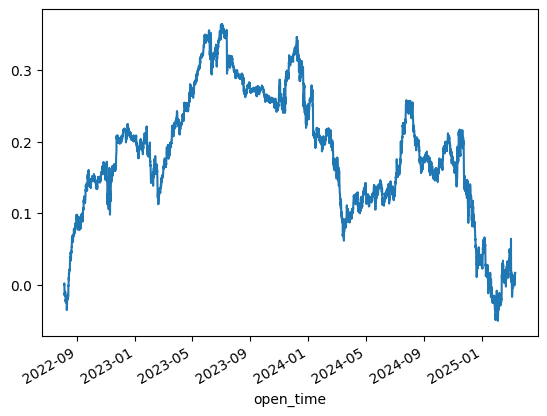

In [37]:
gross_return.cumsum().plot()

In [38]:
to = (port_positions.fillna(0) - port_positions.shift().fillna(0)).abs().sum(1)
to

open_time
2022-08-05 08:00:00    1.000000
2022-08-05 12:00:00    1.111111
2022-08-05 16:00:00    1.111111
2022-08-05 20:00:00    0.444444
2022-08-06 00:00:00    0.222222
                         ...   
2025-03-10 16:00:00    0.444444
2025-03-10 20:00:00    0.666667
2025-03-11 00:00:00    0.444444
2025-03-11 04:00:00    0.444444
2025-03-11 08:00:00    0.666667
Length: 5694, dtype: float64

In [39]:
tcost_bps = 20 # (commissions + slip)
net_ret = gross_return.subtract(to*tcost_bps*1e-4,fill_value=0)
net_ret

open_time
2022-08-05 08:00:00   -0.002000
2022-08-05 12:00:00   -0.000289
2022-08-05 16:00:00   -0.007138
2022-08-05 20:00:00   -0.011007
2022-08-06 00:00:00    0.000571
                         ...   
2025-03-10 16:00:00   -0.007283
2025-03-10 20:00:00    0.003051
2025-03-11 00:00:00    0.009960
2025-03-11 04:00:00   -0.002552
2025-03-11 08:00:00   -0.000049
Length: 5694, dtype: float64

Net return - small set of coins, max_depth = 5, include data from 3 periods ago, include num_trades as signal.

<Axes: xlabel='open_time'>

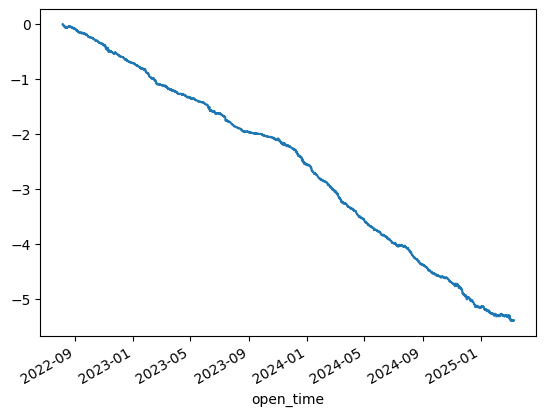

In [40]:
net_ret.cumsum().plot()

In [41]:
net_ret.mean() / net_ret.std() * np.sqrt(365 * day_periods)

-11.087692214550495

Net return - small set of coins, max_depth = 5, include data from 3 periods ago

<Axes: xlabel='open_time'>

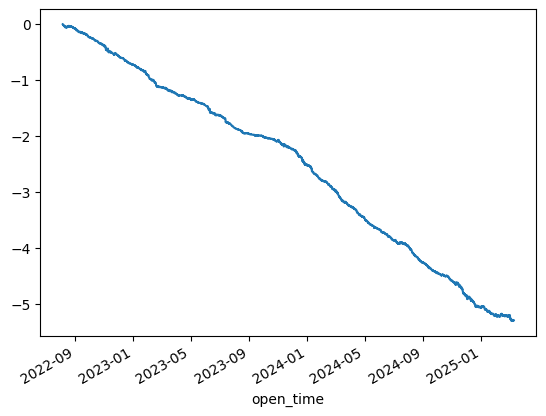

In [109]:
net_ret.cumsum().plot()

In [110]:
net_ret.mean() / net_ret.std() * np.sqrt(365 * day_periods)

-10.862042731050774

Net return - small set of coins, max_depth = 5

<Axes: xlabel='open_time'>

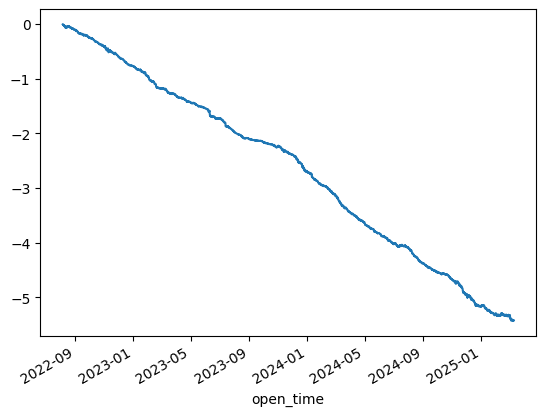

In [72]:
net_ret.cumsum().plot()

In [73]:
net_ret.mean() / net_ret.std() * np.sqrt(365 * day_periods)

-11.082618987237904

Net return - small set of coins, max_depth = 10

<Axes: xlabel='open_time'>

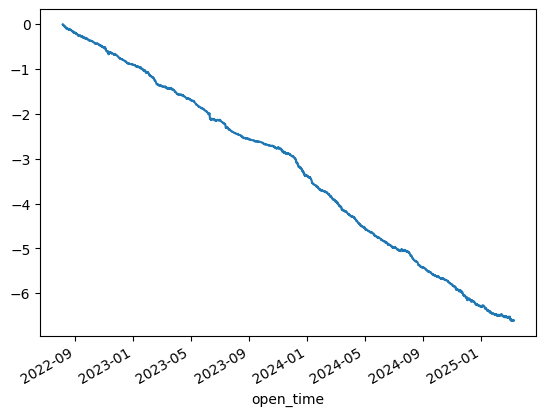

In [50]:
net_ret.cumsum().plot()

In [51]:
net_ret.mean() / net_ret.std() * np.sqrt(365 * day_periods)

-13.336161028926432

Net return - small set of coins, no limits on regressor parameters.

<Axes: xlabel='open_time'>

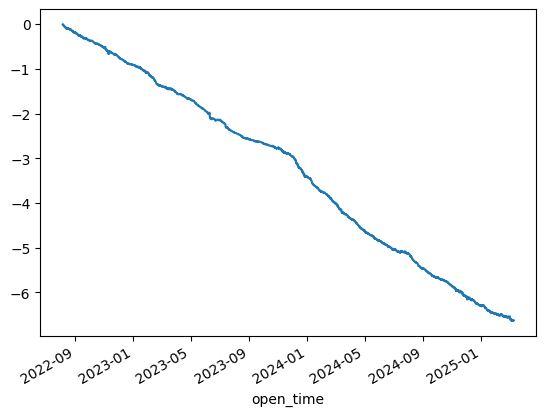

In [28]:
net_ret.cumsum().plot()

In [29]:
net_ret.mean() / net_ret.std() * np.sqrt(365 * day_periods)

-13.327196085694583